In [2]:
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import requests
from datetime import date, datetime
from pathlib import Path
import pandas as pd
import json
import re
from pprint import pprint
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

In [32]:
plt.style.use('fivethirtyeight')
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data

## Dowload FS & Notes

Downloads over 40GB of data!

In [4]:
SEC_URL = 'https://www.sec.gov/files/dera/data/financial-statement-and-notes-data-sets/'

today = pd.Timestamp(date.today())
this_year = today.year
this_quarter = today.quarter

past_years = range(2014, this_year)
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])
for i, (yr, qtr) in enumerate(filing_periods, 1):
    print(yr, qtr, end=' ', )
    filing = f'{yr}q{qtr}_notes.zip'
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)

    response = requests.get(SEC_URL + filing).content
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        continue

2014 1 2014 2 2014 3 2014 4 2015 1 2015 2 2015 3 2015 4 2016 1 2016 2 2016 3 2016 4 2017 1 2017 2 2017 3 2017 4 2018 1 2018 2 2018 3 2018 4 

## Save to parquet

In [5]:
for f in data_path.glob('**/*.tsv'):
    file_name = f.stem  + '.parquet'
    path = Path(f.parents[1]) / 'parquet'
    if (path / file_name).exists():
        continue
    if not path.exists():
        path.mkdir(exist_ok=True)
    try:
        df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False)
    except:
        print(f)
    df.to_parquet(path / file_name)

data/2017_1/source/tag.tsv
data/2015_4/source/txt.tsv
data/2016_1/source/txt.tsv
data/2015_3/source/txt.tsv
data/2017_2/source/tag.tsv
data/2015_1/source/txt.tsv
data/2016_3/source/tag.tsv
data/2017_4/source/tag.tsv
data/2014_4/source/txt.tsv
data/2014_1/source/txt.tsv
data/2014_2/source/txt.tsv
data/2015_2/source/txt.tsv
data/2014_3/source/txt.tsv


## Metadata json

In [6]:
file = data_path / '2018_3' / 'source' / '2018q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

## Submission Data
Get latest submission file

In [7]:
sub = pd.read_parquet(data_path / '2018_3' / 'parquet' / 'sub.parquet')

### Get AAPL submission

In [8]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0000320193-18-000100
cik                        320193
name                    APPLE INC
sic                          3571
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1           ONE APPLE PARK WAY
form                         10-Q
period                   20180630
fy                           2018
fp                             Q3
filed                    20180801
Name: 386, dtype: object

## Build AAPL fundamentals dataset

### Get filings

In [9]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

In [10]:
aapl_subs.form.value_counts()

10-Q    15
10-K     4
Name: form, dtype: int64

### Get numerical filing data

In [11]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

738
1345
707
961
1001
905
951
1277
937
751
923
793
1364
1271
682
805
942
919
952


In [12]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18224 entries, 84837 to 5467444
Data columns (total 15 columns):
adsh        18224 non-null object
tag         18224 non-null object
version     18224 non-null object
ddate       18224 non-null datetime64[ns]
qtrs        18224 non-null int64
uom         18224 non-null object
iprx        18224 non-null float64
value       18176 non-null float64
footnote    68 non-null object
footlen     18224 non-null int64
dimn        18224 non-null int64
coreg       0 non-null object
durp        18224 non-null float64
datp        18224 non-null float64
dcml        18224 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(6)
memory usage: 2.2+ MB


In [13]:
aapl_nums.shape

(18224, 15)

In [14]:
aapl_nums = pd.read_parquet(data_path / 'aapl_nums.parquet')
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18224 entries, 84837 to 5467444
Data columns (total 15 columns):
adsh        18224 non-null object
tag         18224 non-null object
version     18224 non-null object
ddate       18224 non-null datetime64[ns]
qtrs        18224 non-null int64
uom         18224 non-null object
iprx        18224 non-null float64
value       18176 non-null float64
footnote    68 non-null object
footlen     18224 non-null int64
dimn        18224 non-null int64
coreg       0 non-null object
durp        18224 non-null float64
datp        18224 non-null float64
dcml        18224 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(6)
memory usage: 2.2+ MB


## Create P/E Ratio from EPS and stock price data

In [15]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

In [16]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

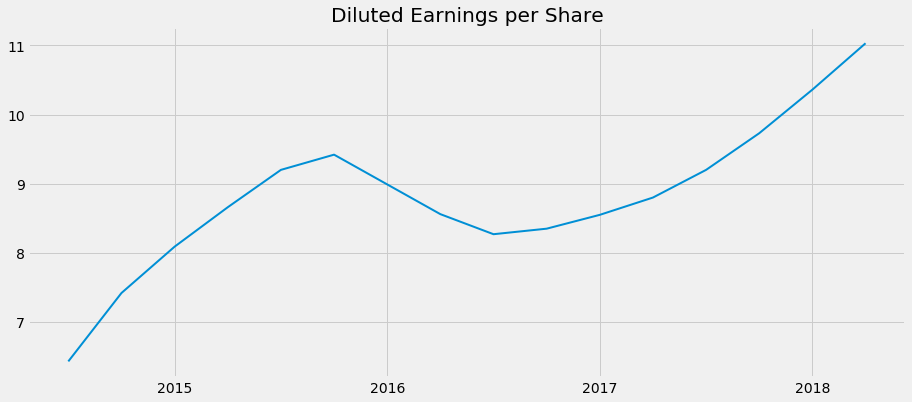

In [17]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);

In [18]:
import pandas_datareader.data as web
import datetime
symbol = 'AAPL.US'

aapl_stock = (web.
              DataReader(symbol, 'quandl', start=eps.index.min())
              .resample('D')
              .last()
             .loc['2014':eps.index.max()])
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2014-09-30 to 2018-03-27
Freq: D
Data columns (total 12 columns):
Open          877 non-null float64
High          877 non-null float64
Low           877 non-null float64
Close         877 non-null float64
Volume        877 non-null float64
ExDividend    877 non-null float64
SplitRatio    877 non-null float64
AdjOpen       877 non-null float64
AdjHigh       877 non-null float64
AdjLow        877 non-null float64
AdjClose      877 non-null float64
AdjVolume     877 non-null float64
dtypes: float64(12)
memory usage: 129.5 KB


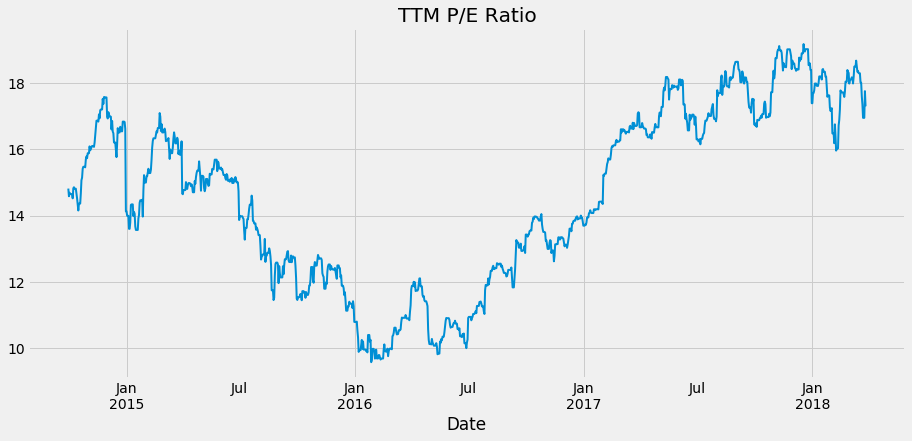

In [19]:
pe = aapl_stock.AdjClose.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [20]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2014-09-30 to 2018-03-27
Freq: D
Data columns (total 3 columns):
price        1275 non-null float64
eps          1275 non-null float64
P/E Ratio    1275 non-null float64
dtypes: float64(3)
memory usage: 39.8 KB


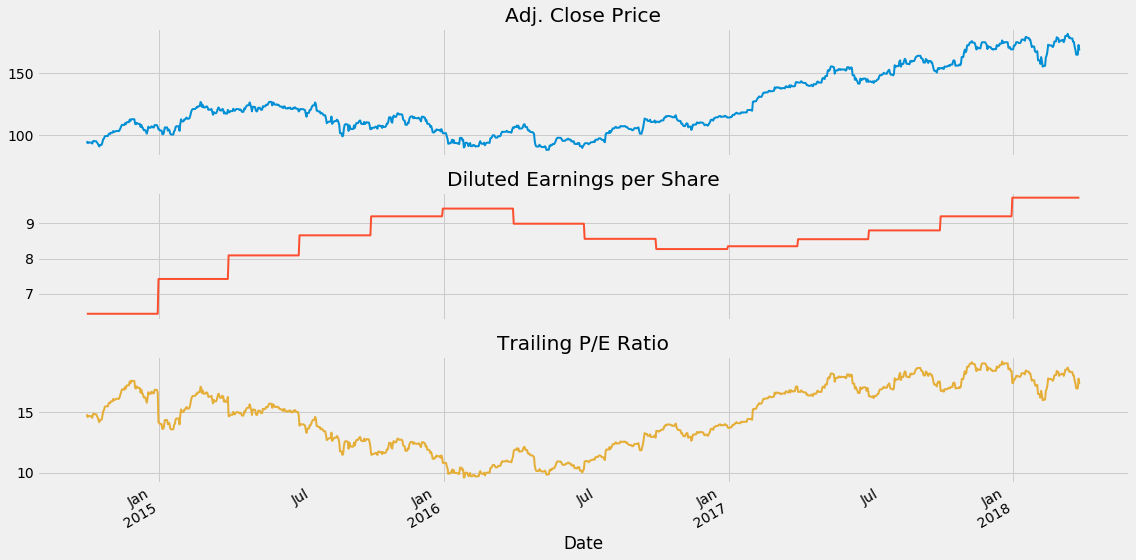

In [21]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

In [22]:
aapl_nums.tag.value_counts()

DebtInstrumentInterestRateEffectivePercentage                                                                        573
CashAndCashEquivalentsAtCarryingValue                                                                                570
SalesRevenueNet                                                                                                      544
AvailableForSaleSecuritiesNoncurrent                                                                                 532
AvailableForSaleSecurities                                                                                           532
AvailableForSaleSecuritiesCurrent                                                                                    532
AvailableForSaleSecuritiesAmortizedCost                                                                              532
AvailableForSaleSecuritiesAccumulatedGrossUnrealizedLossBeforeTax                                                    476
AvailableForSaleSecuritiesAccumu

In [23]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

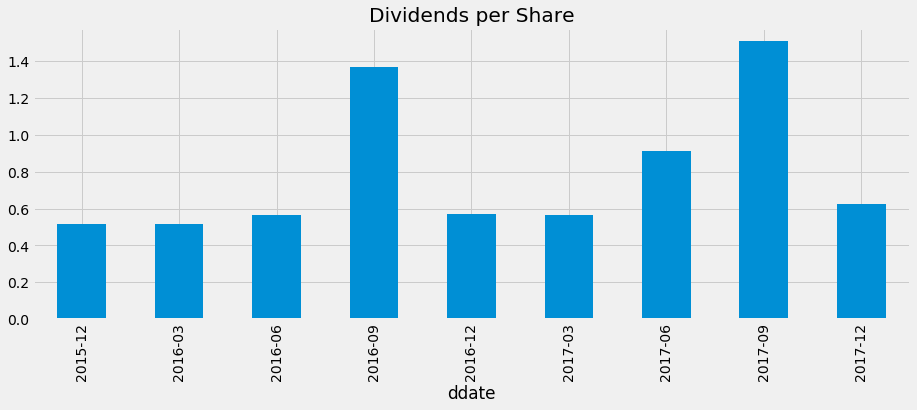

In [24]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [25]:
txt = pd.read_parquet(data_path / '2018_2' / 'parquet' /  'txt.parquet')
apple_txt = txt[txt.adsh == apple.adsh]

In [26]:
apple_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 20 columns):
adsh        0 non-null object
tag         0 non-null object
version     0 non-null object
ddate       0 non-null int64
qtrs        0 non-null int64
iprx        0 non-null int64
lang        0 non-null object
dcml        0 non-null int64
durp        0 non-null float64
datp        0 non-null float64
dimh        0 non-null object
dimn        0 non-null int64
coreg       0 non-null object
escaped     0 non-null int64
srclen      0 non-null int64
txtlen      0 non-null int64
footnote    0 non-null object
footlen     0 non-null int64
context     0 non-null object
value       0 non-null object
dtypes: float64(2), int64(9), object(9)
memory usage: 0.0+ bytes


In [27]:
apple_txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value


In [28]:
tags = pd.read_parquet(data_path / '2018_1'/ 'parquet' / 'tag.parquet')
tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876087 entries, 0 to 876086
Data columns (total 9 columns):
tag         876085 non-null object
version     876087 non-null object
custom      876087 non-null int64
abstract    876087 non-null int64
datatype    821031 non-null object
iord        509567 non-null object
crdr        250009 non-null object
tlabel      875600 non-null object
doc         810912 non-null object
dtypes: int64(2), object(7)
memory usage: 66.8+ MB


In [29]:
tags.head()

,tag,version,custom,abstract,datatype,iord,crdr,tlabel,doc
0,EntityDomain,dei/2014,0,1,member,None,None,Entity [Domain],All the names of the entities being reported u...
1,LegalEntityAxis,dei/2014,0,1,axis,None,None,Legal Entity [Axis],The set of legal entities associated with a re...
2,EntityPublicFloat,dei/2014,0,0,monetary,I,C,Entity Public Float,State aggregate market value of voting and non...
3,DocumentFiscalYearFocus,dei/2014,0,0,gYear,D,None,Document Fiscal Year Focus,This is focus fiscal year of the document repo...
4,DocumentPeriodEndDate,dei/2014,0,0,date,D,None,Document Period End Date,The end date of the period reflected on the co...


In [30]:
apple_txt.merge(tags, how='left').info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 27 columns):
adsh        0 non-null object
ddate       0 non-null int64
qtrs        0 non-null int64
iprx        0 non-null int64
lang        0 non-null object
dcml        0 non-null int64
durp        0 non-null float64
datp        0 non-null float64
dimh        0 non-null object
dimn        0 non-null int64
coreg       0 non-null object
escaped     0 non-null int64
srclen      0 non-null int64
txtlen      0 non-null int64
footnote    0 non-null object
footlen     0 non-null int64
context     0 non-null object
value       0 non-null object
tag         0 non-null object
version     0 non-null object
custom      0 non-null int64
abstract    0 non-null int64
datatype    0 non-null object
iord        0 non-null object
crdr        0 non-null object
tlabel      0 non-null object
doc         0 non-null object
dtypes: float64(2), int64(11), object(14)
memory usage: 0.0+ bytes


Unfortunately this gets truncated. Back to XBRL source..

In [31]:
apple_txt.sort_values('txtlen', ascending=False).loc[:, ['srclen', 'txtlen', 'tag', 'value']].head(20)

,srclen,txtlen,tag,value
